# Notebook for visualizing consumption data
This notebook is used to visualize the consumption data from Paraguay. It includes code for loading the data, preprocessing it, and creating various plots to analyze the consumption patterns.

#### Print the first few rows

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the raw consumption data
consumption_path = '../../data/paraguay/electricity-consumption-raw.csv'
df_consumption = pd.read_csv(consumption_path)

In [2]:
# Identify feeder columns (assuming time columns are first, feeders are the rest)
time_cols = [col for col in df_consumption.columns if 'time' in col.lower() or 'date' in col.lower()]
feeder_cols = [col for col in df_consumption.columns if col not in time_cols]

In [3]:
# If the feeder column is named 'feeder', get all unique feeders
if 'feeder' in df_consumption.columns:
    unique_feeders = df_consumption['feeder'].unique()

### Plot feeders

In [ ]:
feeders_to_plot = unique_feeders[:1]  # Plot first 2 feeders for clarity
plt.figure(figsize=(14, 5))
for feeder_name in feeders_to_plot:
    df_f = df_consumption[df_consumption['feeder'] == feeder_name].sort_values('datetime')
    rolling = df_f['consumption'].rolling(window=24, min_periods=1).mean()
    plt.plot(df_f['datetime'], rolling, linestyle='-', linewidth=2, label=f"{feeder_name} (rolling 24h)")

plt.xlabel('Datetime')
plt.ylabel('Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

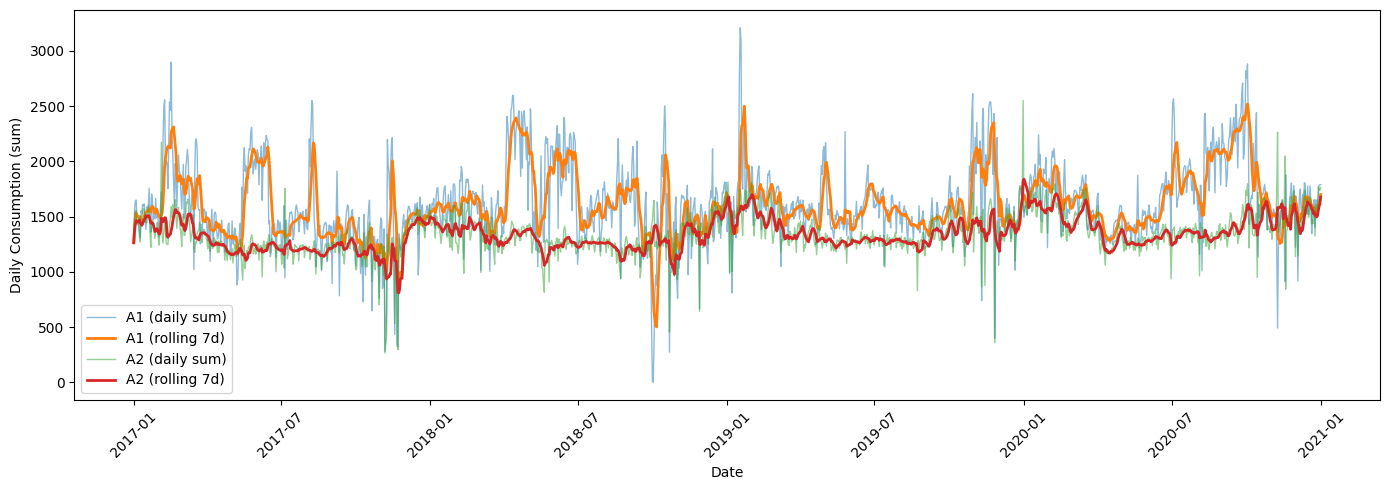

In [ ]:
feeders_to_plot = unique_feeders[:2]  # Plot first 2 feeders for clarity
plt.figure(figsize=(14, 5))
window = 7  # 7-day sliding window

for feeder_name in feeders_to_plot:
    df_f = df_consumption[df_consumption['feeder'] == feeder_name].copy()
    # Ensure datetime is datetime type
    df_f['date'] = pd.to_datetime(df_f['datetime']).dt.date
    # Group by date and sum consumption for each day
    daily_sum = df_f.groupby('date')['consumption'].sum()
    # Apply sliding window (rolling mean)
    daily_rolling = daily_sum.rolling(window=window, min_periods=1).mean()
    plt.plot(daily_sum.index, daily_sum.values, linestyle='-', linewidth=1, alpha=0.5, label=f"{feeder_name} (daily sum)")
    plt.plot(daily_rolling.index, daily_rolling.values, linestyle='-', linewidth=2, label=f"{feeder_name} (rolling {window}d)")

plt.xlabel('Date')
plt.ylabel('Daily Consumption (sum)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Detect outliers

In [ ]:
# Detect outliers per feeder using IQR and Z-score methods
from scipy.stats import zscore

# Choose the column names for feeder, consumption, and time
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

feeder_col = get_col(df_consumption.columns, ['feeder', 'Feeder'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])
time_col = time_cols[0] if time_cols else None

if feeder_col and cons_col:
    outlier_results = []
    for feeder, group in df_consumption.groupby(feeder_col):
        # IQR method
        q1 = group[cons_col].quantile(0.25)
        q3 = group[cons_col].quantile(0.75)
        iqr = q3 - q1
        iqr_mask = (group[cons_col] < (q1 - 1.5 * iqr)) | (group[cons_col] > (q3 + 1.5 * iqr))
        iqr_outliers = group[iqr_mask]
        # Z-score method
        zscores = zscore(group[cons_col].dropna())
        z_mask = abs(zscores) > 3
        z_outliers = group.loc[group[cons_col].dropna().index[z_mask]]
        outlier_results.append({
            'Feeder': feeder,
            'IQR Outliers': len(iqr_outliers),
            'Z Outliers': len(z_outliers),
            'Sample IQR Outlier Times': iqr_outliers[time_col].head(3).tolist() if time_col and not iqr_outliers.empty else [],
            'Sample Z Outlier Times': z_outliers[time_col].head(3).tolist() if time_col and not z_outliers.empty else []
        })
    outlier_df = pd.DataFrame(outlier_results)
    display(outlier_df)
else:
    print("Required columns not found for outlier detection.")

,Feeder,IQR Outliers,Z Outliers,Sample IQR Outlier Times,Sample Z Outlier Times
0,A1,1109,381,"[2017-01-16 13:00:00, 2017-02-06 20:00:00, 201...","[2017-02-06 20:00:00, 2017-02-07 20:00:00, 201..."
1,A2,553,96,"[2017-01-03 21:00:00, 2017-01-04 21:00:00, 201...","[2017-01-19 11:00:00, 2017-02-04 16:00:00, 201..."
2,B1,93,90,"[2017-01-16 23:00:00, 2017-03-22 01:00:00, 201...","[2017-01-16 23:00:00, 2017-03-22 01:00:00, 201..."
3,B2,128,72,"[2017-01-12 17:00:00, 2017-01-18 17:00:00, 201...","[2017-02-24 21:00:00, 2017-12-15 17:00:00, 201..."
4,B3,19,20,"[2017-04-12 01:00:00, 2017-06-18 19:00:00, 201...","[2017-04-12 01:00:00, 2017-06-18 19:00:00, 201..."
5,B4,115,79,"[2017-03-22 22:00:00, 2017-05-07 06:00:00, 201...","[2017-03-22 22:00:00, 2017-05-07 06:00:00, 201..."
6,B5,1974,507,"[2017-01-01 01:00:00, 2017-01-01 02:00:00, 201...","[2017-01-02 20:00:00, 2017-01-02 21:00:00, 201..."
7,B6,2310,760,"[2017-02-12 19:00:00, 2017-02-12 20:00:00, 201...","[2017-02-12 19:00:00, 2017-02-12 20:00:00, 201..."
8,C1,258,152,"[2017-01-02 21:00:00, 2017-01-03 21:00:00, 201...","[2017-01-12 20:00:00, 2017-01-12 21:00:00, 201..."
9,C2,523,184,"[2017-01-02 21:00:00, 2017-01-03 06:00:00, 201...","[2017-01-03 20:00:00, 2017-01-04 20:00:00, 201..."


### Plotting Frequency Distribution for Feeder 'A1' with Outlier Boundaries
This cell plots the histogram of the consumption values for feeder 'A1', showing the IQR and Z-score outlier boundaries.

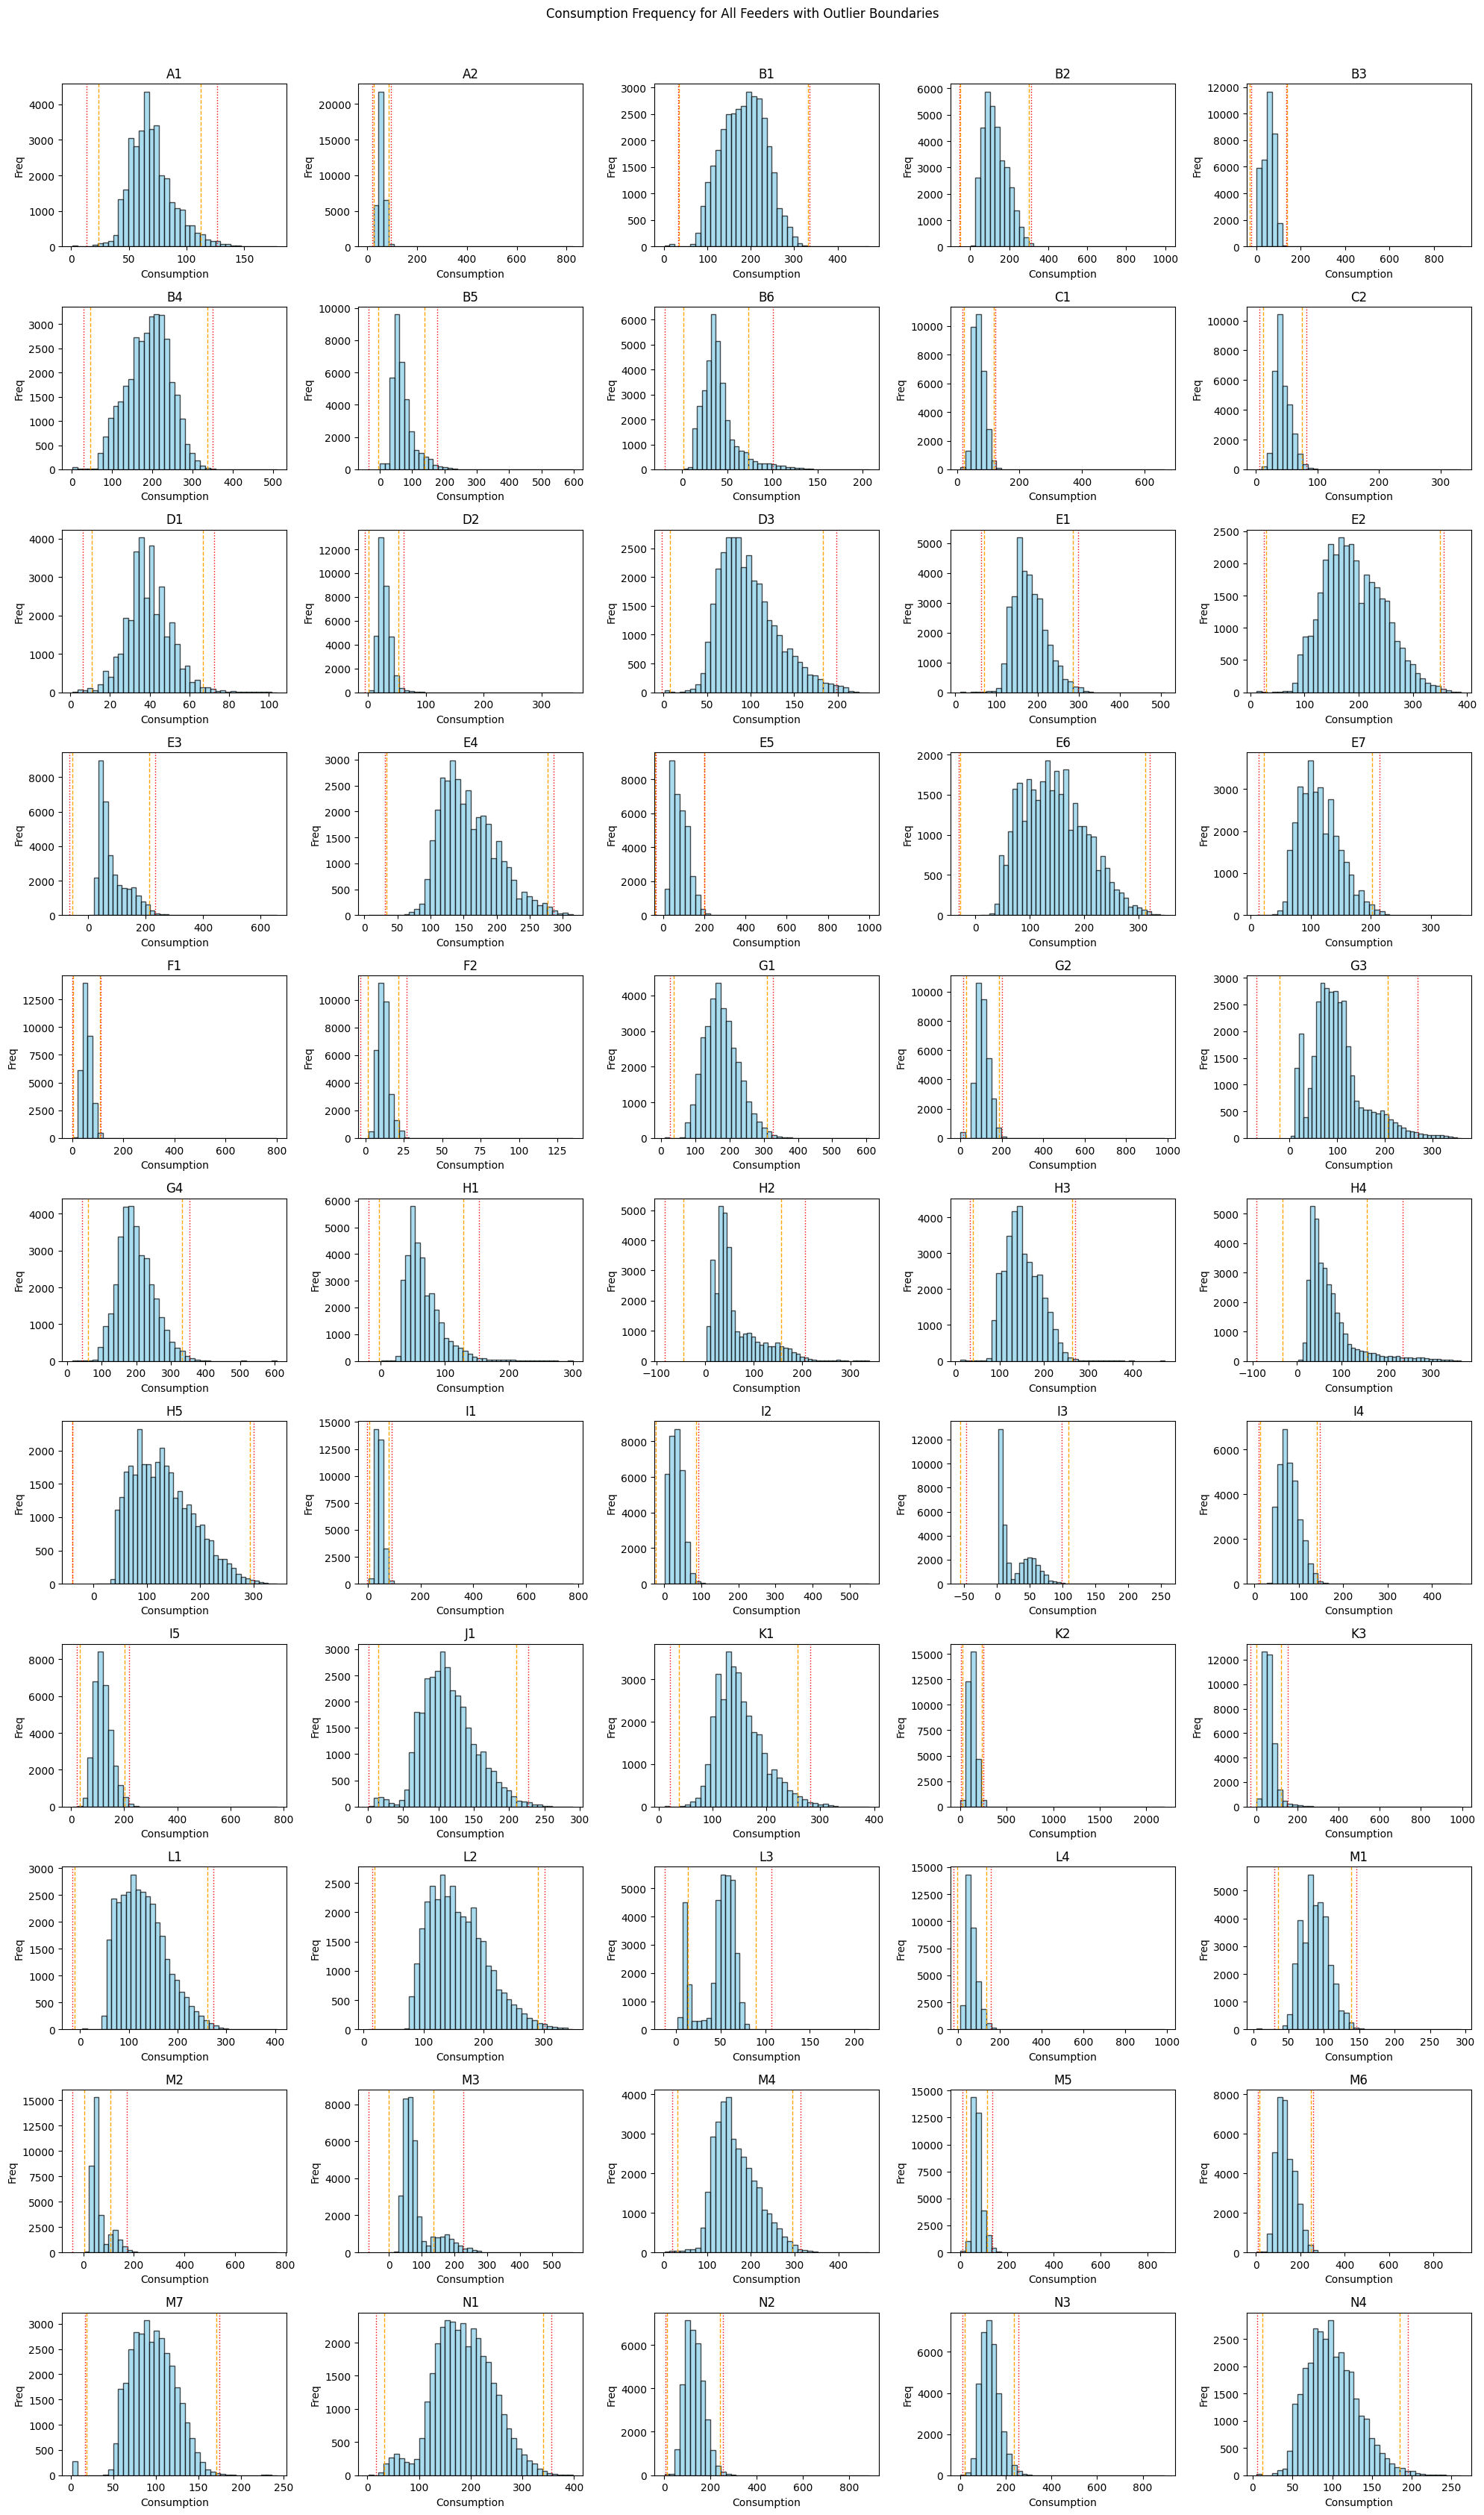

In [ ]:
# Plot frequency histograms for all feeders with IQR and Z-score boundaries as subplots

feeders = unique_feeders
n_feed = len(feeders)
ncols = 5
nrows = int(np.ceil(n_feed / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), sharex=False, sharey=False)
axes = axes.flatten()

for idx, feeder in enumerate(feeders):
    df_f = df_consumption[df_consumption[feeder_col] == feeder]
    values = df_f[cons_col].dropna()
    if len(values) == 0:
        continue
    # IQR boundaries
    q1 = values.quantile(0.25)
    q3 = values.quantile(0.75)
    iqr = q3 - q1
    iqr_low = q1 - 1.5 * iqr
    iqr_high = q3 + 1.5 * iqr
    # Z-score boundaries
    mean = values.mean()
    std = values.std()
    z_low = mean - 3 * std
    z_high = mean + 3 * std
    ax = axes[idx]
    ax.hist(values, bins=40, color='skyblue', edgecolor='k', alpha=0.7)
    ax.axvline(iqr_low, color='orange', linestyle='--', linewidth=1)
    ax.axvline(iqr_high, color='orange', linestyle='--', linewidth=1)
    ax.axvline(z_low, color='red', linestyle=':', linewidth=1)
    ax.axvline(z_high, color='red', linestyle=':', linewidth=1)
    ax.set_title(feeder)
    ax.set_xlabel('Consumption')
    ax.set_ylabel('Freq')
# Hide unused axes
for j in range(idx+1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.suptitle("Consumption Frequency for All Feeders with Outlier Boundaries", y=1.02)
plt.show()

### Plotting Feeder Time Series with Outlier Highlighting (IQR and Z-score)
This cell plots the time series for the selected feeders, highlighting outliers detected by both IQR and Z-score methods.

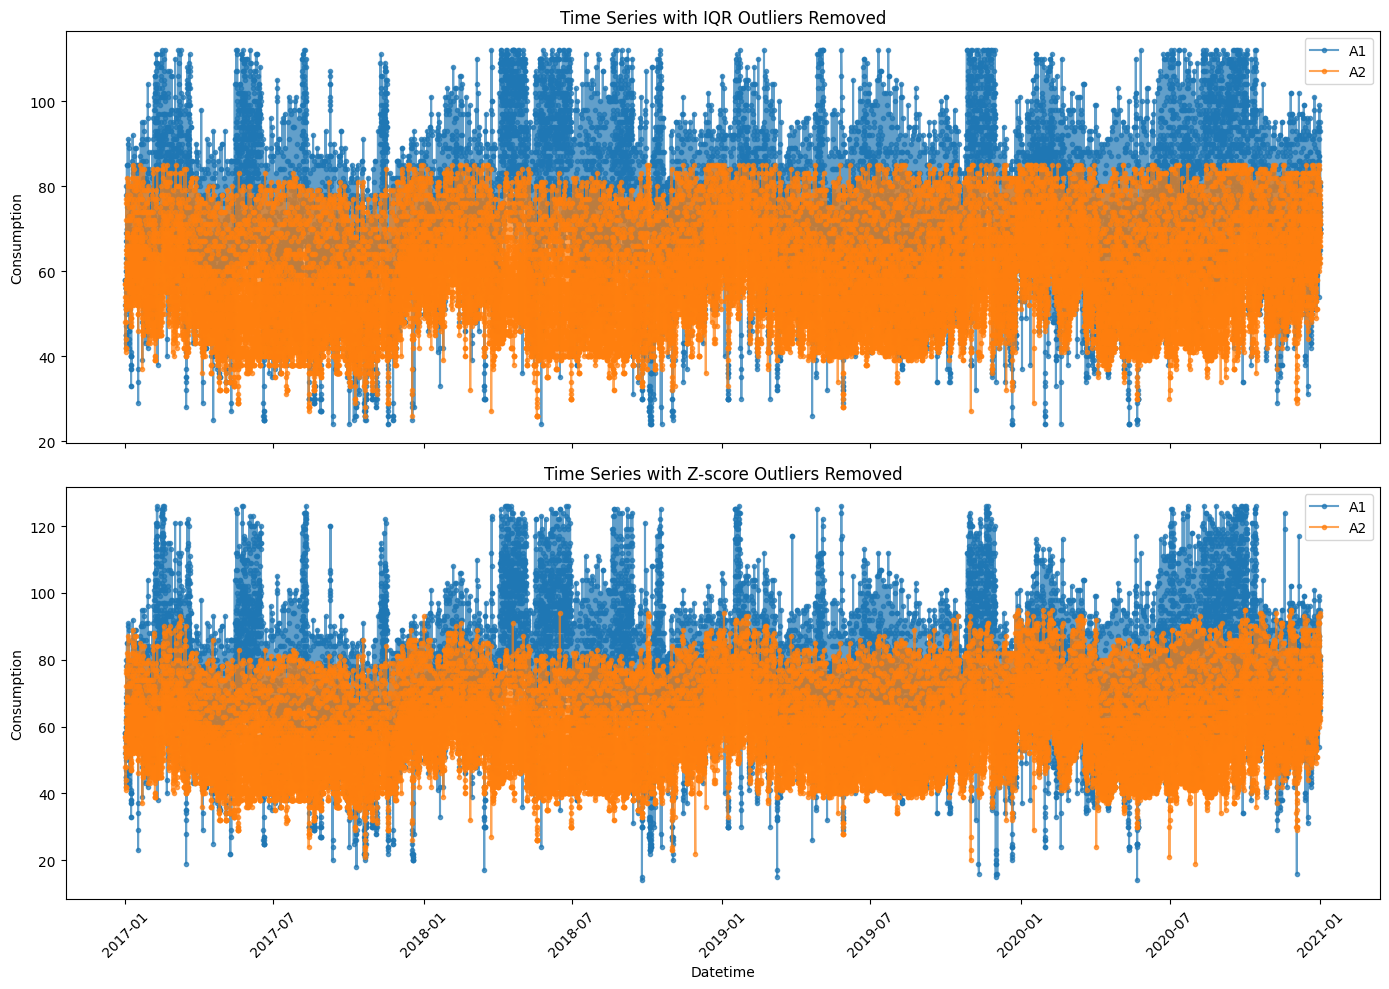

In [ ]:
# Remove outliers and plot subplots for both Z-score and IQR methods

# Helper to get column names
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

feeder_col = get_col(df_consumption.columns, ['feeder', 'Feeder'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])
date_col = get_col(df_consumption.columns, ['datetime', 'date', 'time', 'timestamp'])

if feeder_col and cons_col and date_col:
    feeders_to_plot = unique_feeders[:2]
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    for idx, method in enumerate(['IQR', 'Z']):
        for feeder_name in feeders_to_plot:
            df_f = df_consumption[df_consumption[feeder_col] == feeder_name].copy()
            #mask = df_f[cons_col].notna()
            #axes[idx].set_title('Original Time Series')
            #axes[idx].plot(df_f[date_col][mask], df_f[cons_col][mask], marker='.', linestyle='-', alpha=0.7, label=feeder_name)
            # IQR bounds
            q1 = df_f[cons_col].quantile(0.25)
            q3 = df_f[cons_col].quantile(0.75)
            iqr = q3 - q1
            iqr_low = q1 - 1.5 * iqr
            iqr_high = q3 + 1.5 * iqr
            # Z-score bounds
            mean = df_f[cons_col].mean()
            std = df_f[cons_col].std()
            z_low = mean - 3 * std
            z_high = mean + 3 * std
            if method == 'IQR':
                mask = (df_f[cons_col] >= iqr_low) & (df_f[cons_col] <= iqr_high)
                axes[idx].set_title('Time Series with IQR Outliers Removed')
            else:
                mask = (df_f[cons_col] >= z_low) & (df_f[cons_col] <= z_high)
                axes[idx].set_title('Time Series with Z-score Outliers Removed')
            axes[idx].plot(df_f[date_col][mask], df_f[cons_col][mask], marker='.', linestyle='-', alpha=0.7, label=feeder_name)
        axes[idx].set_ylabel('Consumption')
        axes[idx].legend()
    axes[1].set_xlabel('Datetime')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for plotting subplots with outliers removed.")


### Plotting Total Consumption per Substation Over Time
This cell groups feeders by their substation, sums the consumption for all feeders connected to each substation at each timestamp, and plots the total consumption for each substation over time.

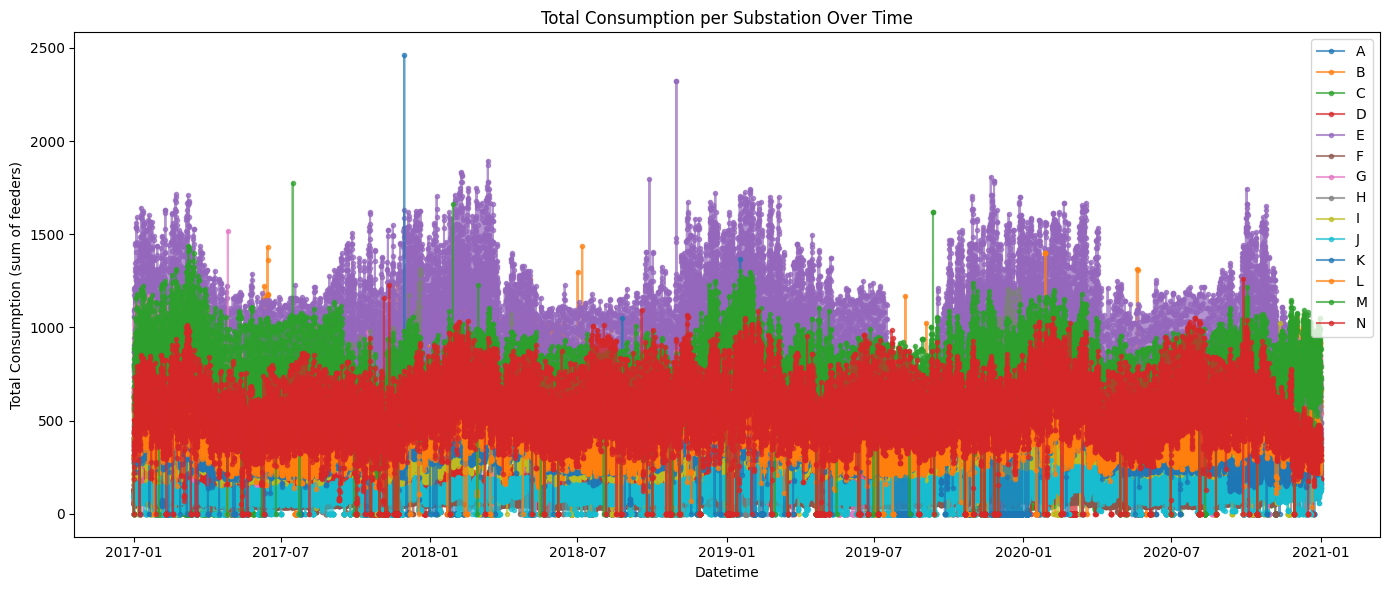

In [ ]:
# Sum all feeders per substation and plot over time
import matplotlib.pyplot as plt

# Helper to get column names
def get_col(colnames, options):
    for opt in options:
        if opt in colnames:
            return opt
    return None

substation_col = get_col(df_consumption.columns, ['substation', 'Substation'])
date_col = get_col(df_consumption.columns, ['datetime', 'date', 'time', 'timestamp'])
cons_col = get_col(df_consumption.columns, ['consumption', 'Consumption'])

if substation_col and date_col and cons_col:
    # Ensure datetime is datetime type
    df_consumption[date_col] = pd.to_datetime(df_consumption[date_col], errors='coerce')
    # Group by substation and datetime, sum consumption
    grouped = df_consumption.groupby([substation_col, date_col])[cons_col].sum().reset_index()
    substations = grouped[substation_col].unique()
    plt.figure(figsize=(14, 6))
    for sub in substations:
        df_sub = grouped[grouped[substation_col] == sub]
        plt.plot(df_sub[date_col], df_sub[cons_col], marker='.', linestyle='-', alpha=0.7, label=sub)
    plt.xlabel('Datetime')
    plt.ylabel('Total Consumption (sum of feeders)')
    plt.title('Total Consumption per Substation Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for substation aggregation plot.")

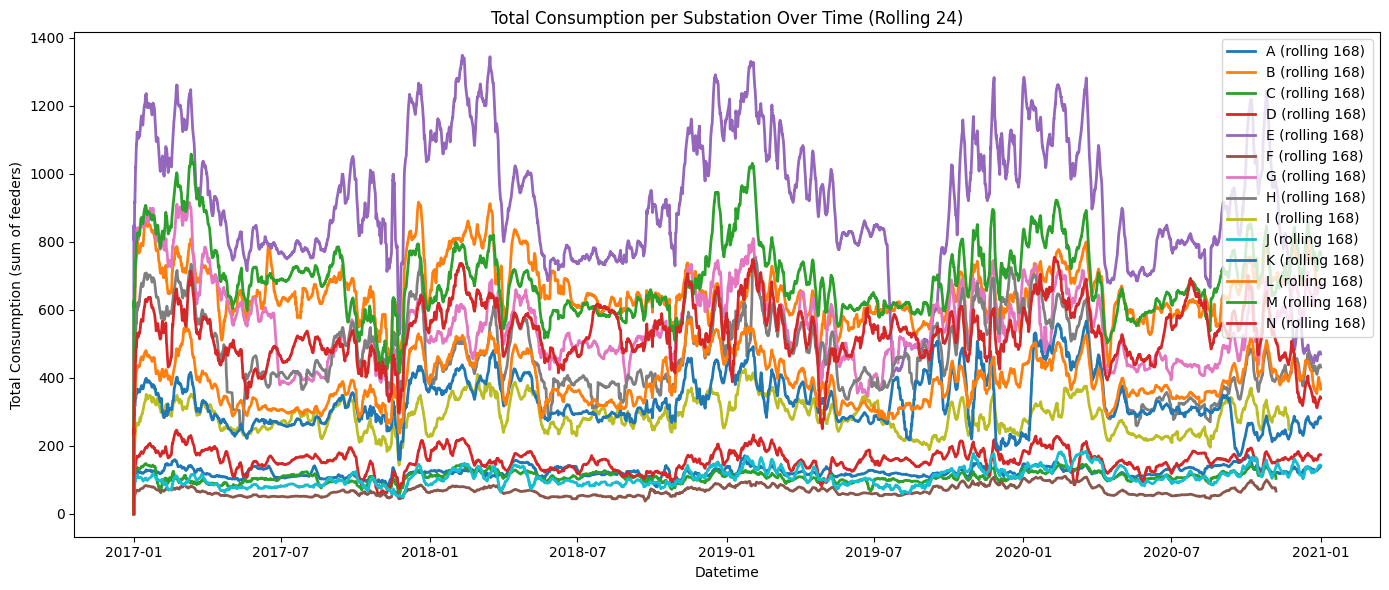

In [ ]:
if substation_col and date_col and cons_col:
    df_consumption[date_col] = pd.to_datetime(df_consumption[date_col], errors='coerce')
    grouped = df_consumption.groupby([substation_col, date_col])[cons_col].sum().reset_index()
    substations = grouped[substation_col].unique()
    plt.figure(figsize=(14, 6))
    window = 24*7  # 24-period sliding window
    for sub in substations:
        df_sub = grouped[grouped[substation_col] == sub].sort_values(date_col)
        rolling = df_sub[cons_col].rolling(window=window, min_periods=1).mean()
        plt.plot(df_sub[date_col], rolling, linestyle='-', linewidth=2, label=f"{sub} (rolling {window})")
    plt.xlabel('Datetime')
    plt.ylabel('Total Consumption (sum of feeders)')
    plt.title('Total Consumption per Substation Over Time (Rolling 24)')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Required columns not found for substation aggregation plot.")
